In [289]:
# Dataset: Analysis of the banking dataset marketing targets.
# Presented by: Tirso Gomez
# Date: 6 Sept 2021
# Category: Test

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/banking-dataset-marketing-targets/train.csv
/kaggle/input/banking-dataset-marketing-targets/test.csv


# Eunoia Machine Learning Test
The scope of this task is to implement a Machine Learning solution of a *Banking Dataset*
### Steps to perform this task:

1.	Preparation and cleaning of data.
* 1.1. Read
* 1.2. The search for missings and duplicates
* 1.3. Pearson Correlation coefficient.
2. Processing, Visualisation and data analysis
* 2.1. Categorical data
* 2.2. Numerical data
3.	Selecting the appropriate features.
* 3.1. Pre-processing
* 3.2. Removing noise
* 3.3. Transforming - Encoding
4.	Logistic Regression model for classification.
5.	Logistic Regression model evaluation: confusion_matrix, classification report, cross validation mean and auc ROC.
6. Oversampling. Overcoming imbalance problem

## 1.	Preparation and Cleaning of Data
Due to ML models and Python require numerical input I have to transform categorical variables in numerical values.
* 1.1. Read
* 1.2. The search for missings and duplicates
* 1.3. Evaluate statistical correlation between features. Pearson Correlation coefficient.

In [290]:
# Read csv file with pandas pd_readcsv
train = pd.read_csv("/kaggle/input/banking-dataset-marketing-targets/train.csv", sep=';')
test = pd.read_csv("/kaggle/input/banking-dataset-marketing-targets/test.csv", sep=';')

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1.2. The search for missings
* a. The dataset does not contain any missing values.
* b. The dataset does not have any duplicate values.
* c. Scanning for white spaces
* d. Value consistency: Scanning for case errors: capitalisation case mistakes and trailing spaces.

In [291]:
# a. Checking missing values
print(train.isna().values.any())
# Verification
print(train.isna().sum())

False
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [292]:
# b. Checking duplicate values
print(train.duplicated().value_counts())

False    45211
dtype: int64


In [293]:
# c. Remove white spaces
train.columns = train.columns.str.replace(' ', '')

#### d. Value consistency of each feature
The "unknown" values (["job = 288 - 0.6%", "education = 1857 - 4.1%", "contact"]) will be imputed since they just have a insignificant proportion wrt. other variables.

In [294]:
job_status = train["job"]
print(job_status.value_counts())

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64


In [295]:
marriage_status = train["marital"]
print(marriage_status.value_counts())

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64


In [296]:
education_status = train["education"]
print(education_status.value_counts())

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


In [297]:
default_status = train["default"]
print(default_status.value_counts())

no     44396
yes      815
Name: default, dtype: int64


In [298]:
housing_status = train["housing"]
print(housing_status.value_counts())

yes    25130
no     20081
Name: housing, dtype: int64


In [299]:
contact = train["contact"]
print(contact.value_counts())

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64


In [300]:
loan_status = train["loan"]
print(loan_status.value_counts())

no     37967
yes     7244
Name: loan, dtype: int64


In [301]:
previous_status = train["previous"]
print(previous_status.value_counts())
36954

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
27         5
24         5
21         4
29         4
25         4
30         3
26         2
37         2
28         2
38         2
40         1
275        1
51         1
55         1
35         1
32         1
58         1
41         1
Name: previous, dtype: int64


36954

In [302]:
poutcome_status = train["poutcome"]
print(poutcome_status.value_counts())

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64


In [303]:
y_status = train["y"]
print(y_status.value_counts())

no     39922
yes     5289
Name: y, dtype: int64


In [304]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1.3. Pearson Correlation Coefficient
There is no correlation, no relationship between the independent variables.So, it is good practice to check it before selecting the variables into the regression model since is one of the steps to avoid overfitting. Correlation matrix: (0<=|c|<0.3: weak), (3<=|c|<0.7: moderate) & (0.7<=|c|<1: strong)

In [305]:
print(train.corr())

               age   balance       day  duration  campaign     pdays  previous
age       1.000000  0.097783 -0.009120 -0.004648  0.004760 -0.023758  0.001288
balance   0.097783  1.000000  0.004503  0.021560 -0.014578  0.003435  0.016674
day      -0.009120  0.004503  1.000000 -0.030206  0.162490 -0.093044 -0.051710
duration -0.004648  0.021560 -0.030206  1.000000 -0.084570 -0.001565  0.001203
campaign  0.004760 -0.014578  0.162490 -0.084570  1.000000 -0.088628 -0.032855
pdays    -0.023758  0.003435 -0.093044 -0.001565 -0.088628  1.000000  0.454820
previous  0.001288  0.016674 -0.051710  0.001203 -0.032855  0.454820  1.000000


## 2. Processing, Visualisation and  Data Analysis
Next up it is presented a brief Data Exploration and Visualisation: Bivariate analysis and plots of each feature by target Y. 

* 2.1. Categorical data: Bar charts: Goal. Analysis of frequency by category.
* 2.2. Numerical data: Box plots. Goal: Detect any outliers.

#### 2.1. Categorical Features: ["job", "marital", "education", "default", "housing", "loan", "poutcome", "y"]

#### a. job Feature
The bank contacted more on people with professional profiles. Most of the term deposit takers have a high qualification with regards to others.

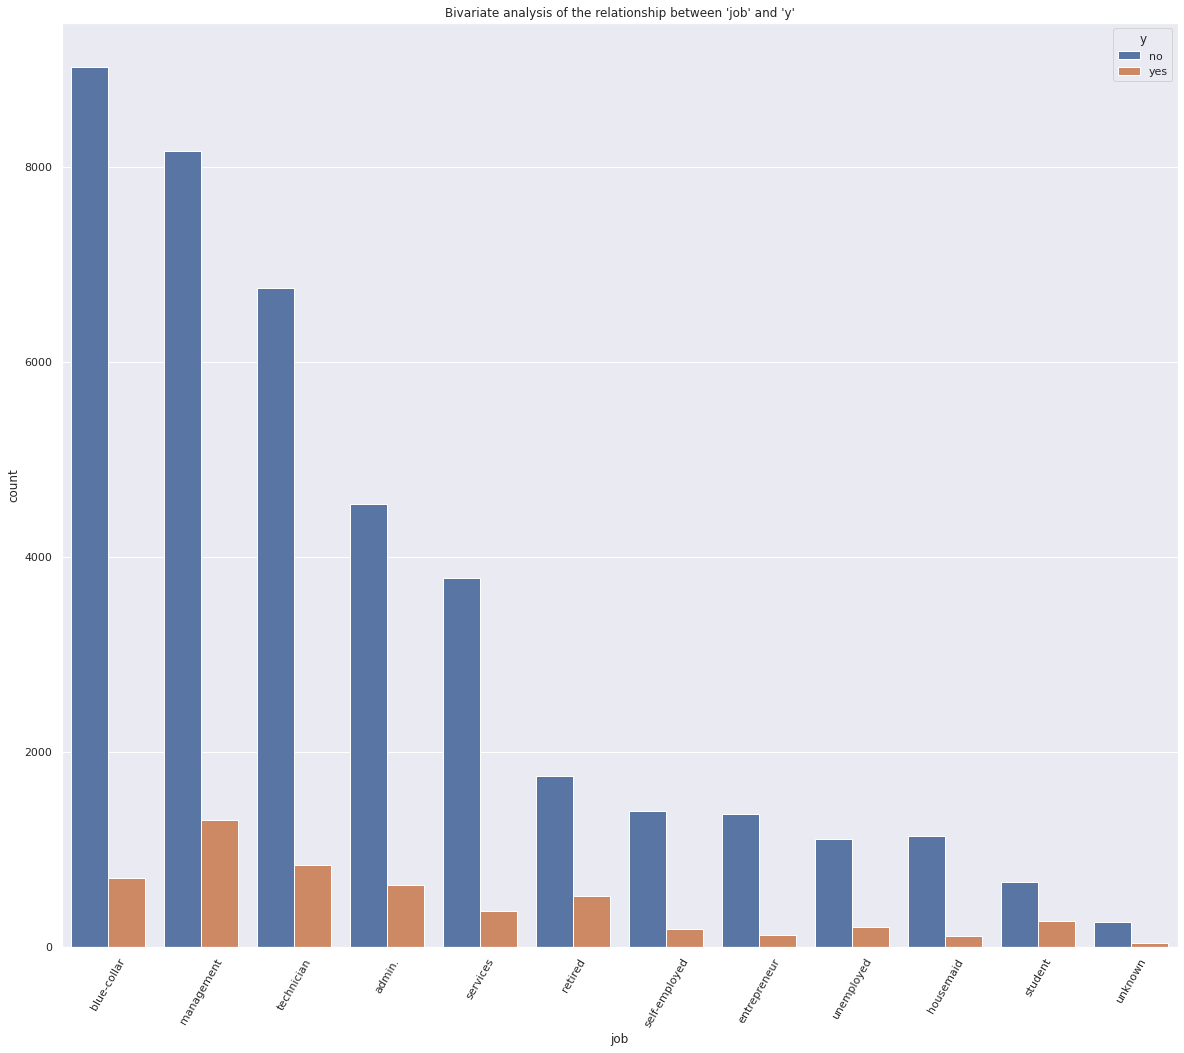

In [306]:
sns.set_theme(style='darkgrid')
job = sns.countplot(x="job", data = train, hue = "y", order = train["job"].value_counts().index)
job.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'job' and 'y'")
plt.show()


#### b. marital Feature
The bank was interested more on married people and single than divorced. The three variables are presented in descending order. Direct relation of samples wrt. the target column. The most "married" samples meant more subscribers.

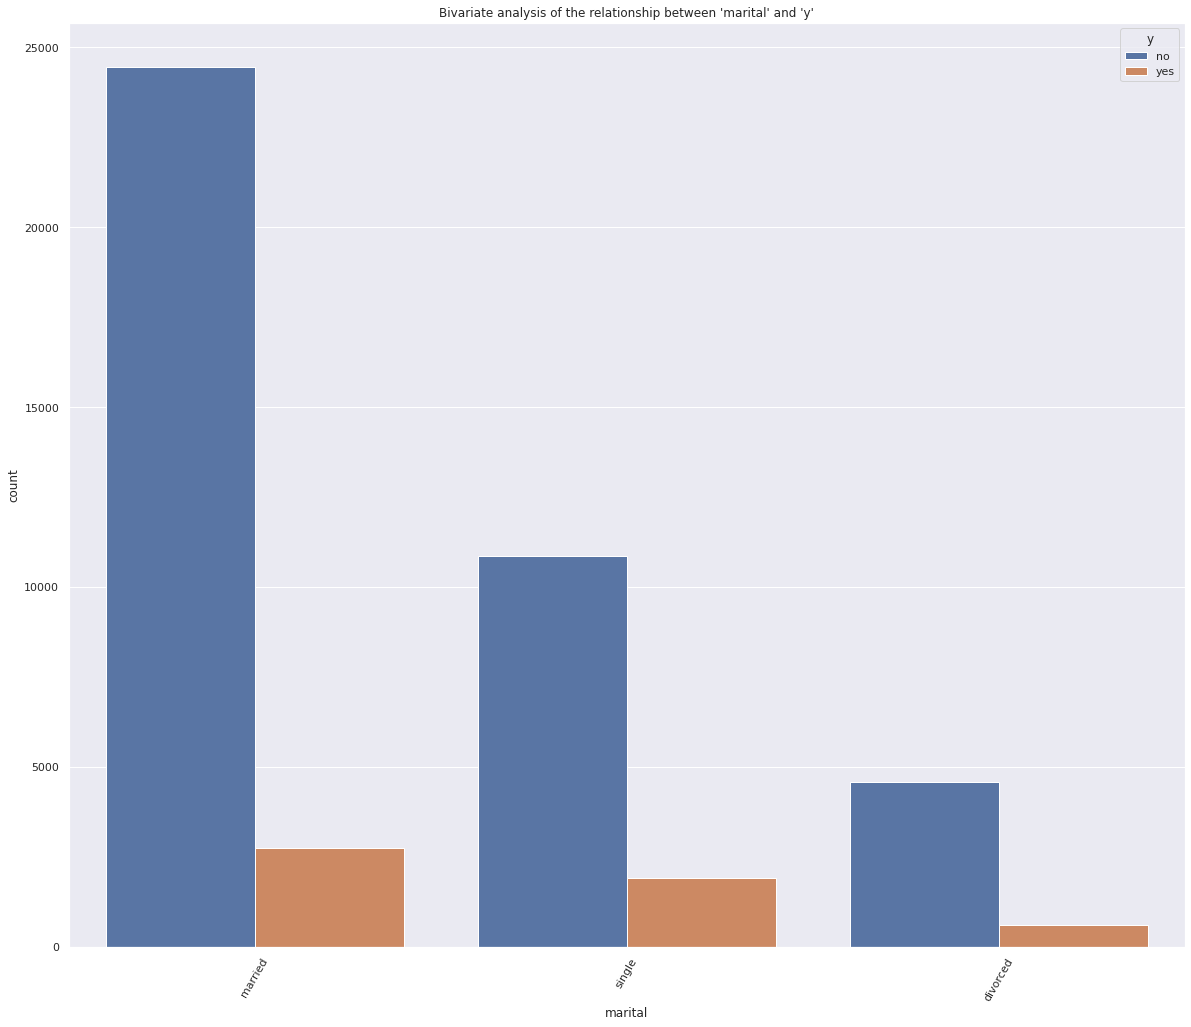

In [307]:
sns.set_theme(style='darkgrid')
marital = sns.countplot(x="marital", data = train, hue = "y", order = train["marital"].value_counts().index)
marital.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'marital' and 'y'")
plt.show()

#### c. education Feature
More people with higher education degrees were subscribed. Proportional relationship. More secondary profiles means more  term deposit were sold.

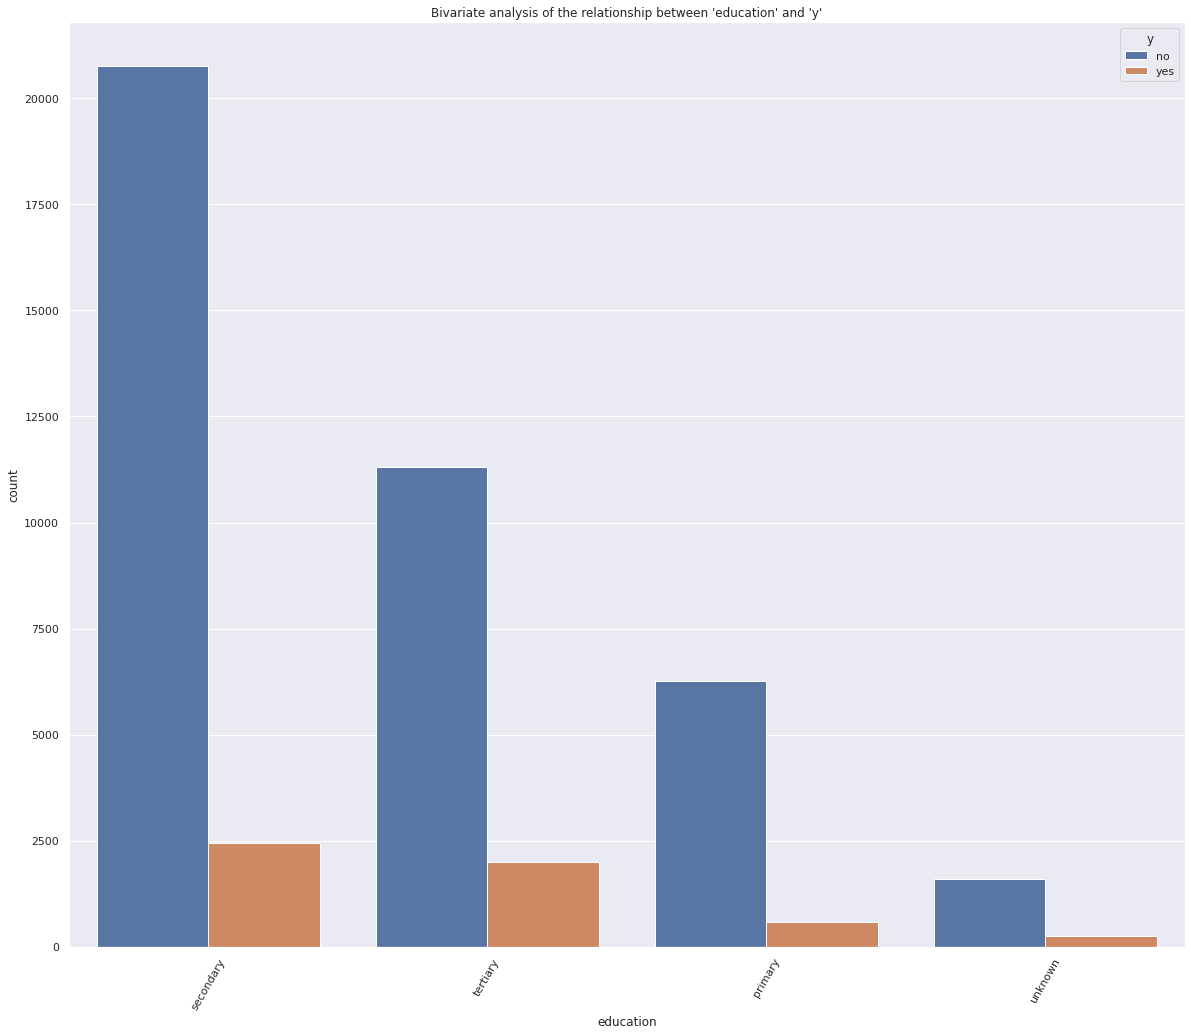

In [308]:
sns.set_theme(style='darkgrid')
education = sns.countplot(x="education", data = train, hue = "y", order = train["education"].value_counts().index)
education.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'education' and 'y'")
plt.show()

#### d. default Feature
A high proportion of non-defaulters corresponds to the total of term deposit takers. It seems that it makes good sense that people with credit do not want to subscribe to a new bank offer.

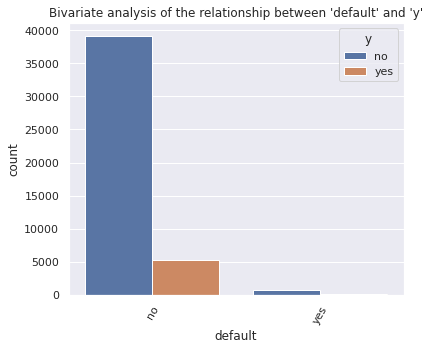

In [309]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
default = sns.countplot(x="default", data = train, hue = "y", order = train["default"].value_counts().index)
default.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'default' and 'y'")
plt.show()

#### e. housing Default
There are more people with a housing loan. People without a housing loan are in higher proportion decided to got subscribed to a term deposit. Inverse proportion relationship.

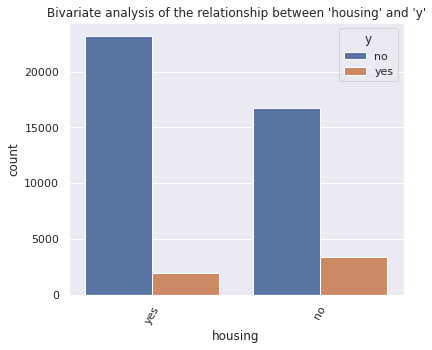

In [310]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
housing = sns.countplot(x="housing", data = train, hue = "y", order = train["housing"].value_counts().index)
housing.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'housing' and 'y'")
plt.show()

#### f. loan
Likewise to housing loan, people without a personal loan were willing to got a deposit term (Higher proportion than housing loan). Just a few people with personal loan decided to got subscribed. Direct proportion relation.

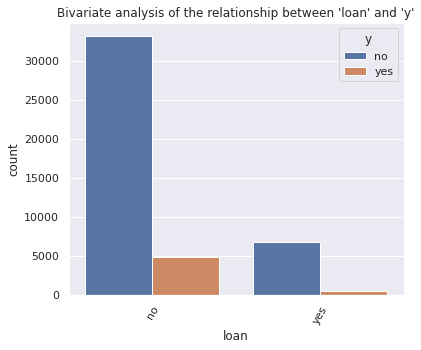

In [311]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
loan = sns.countplot(x="loan", data = train, hue = "y", order = train["loan"].value_counts().index)
loan.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'loan' and 'y'")
plt.show()

#### g. contact Feature
The direct ratio in this graph shows that people who were contacted by cellular got subscribed more to a deposit term. As for the "unknown" variable, an imputation technique will be applied to process it along with the other variables.

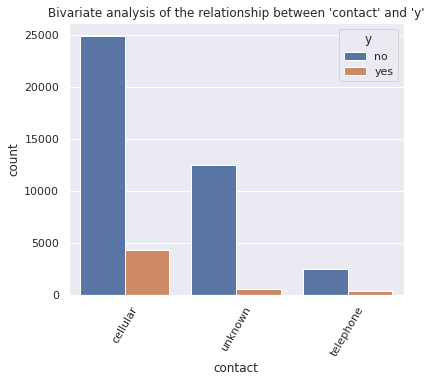

In [312]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
contact = sns.countplot(x="contact", data = train, hue = "y", order = train["contact"].value_counts().index)
contact.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'contact' and 'y'")
plt.show()

#### h. month
May got an slightly more subscribers than the other months. Regardless how many people is contacted the subscription average is almost the same with the exception of December and January. These months were got the fewest subscriptions. One possible reasons could be the fact the people go for holidays. (In the Americas people are used to take holidays in this period of the year). Based on the fact that he plot shows  aproportional distribution of "yes" the "month" feature will be removed since doesn't affect the outcome. 

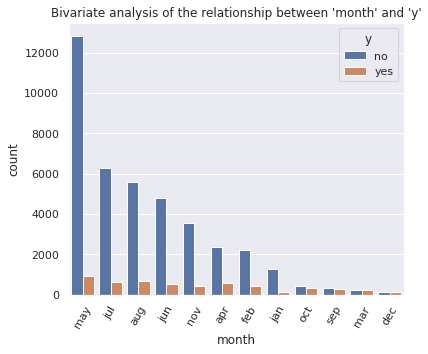

In [313]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
month = sns.countplot(x="month", data = train, hue = "y", order = train["month"].value_counts().index)
month.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'month' and 'y'")
plt.show()

#### i. poutcome Feature
This one correspond to the outcome of success of the previous marketing campaign. What does mean "unknown"? It means, that 78.7% of the people contacted did not know about the previous marketing campaign. "success" has a very small percentage, but relevant for the analysis.

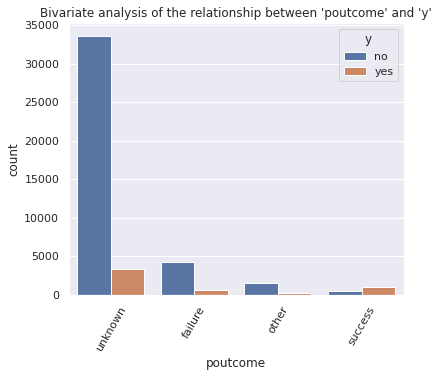

In [314]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
poutcome = sns.countplot(x="poutcome", data = train, hue = "y", order = train["poutcome"].value_counts().index)
poutcome.tick_params(axis='x', rotation=60)
plt.title("Bivariate analysis of the relationship between 'poutcome' and 'y'")
plt.show()

#### j. Target Y
A great number of people contacted did not want to subscribe to the product offered by the bank. Just the **13,2%** said *yes*. This hugh difference shows an imbalanced class problem. This issue will be treated using oversampling.

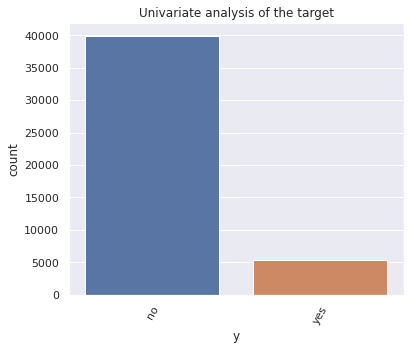

In [315]:
sns.set_theme(style='darkgrid')
sns.set(rc = {'figure.figsize':(6, 5)})
target = sns.countplot(x="y", data = train, order = train["y"].value_counts().index)
target.tick_params(axis='x', rotation=60)
plt.title("Univariate analysis of the target")
plt.show()

#### 2.2. Numerical Features: ["age", "balance", "duration", "campaign", "pdays", "previous"]
For this subsection are presented box-plots analysis and histograms. Moreover, it is plotted the median, mean and mode for each feature.

#### a. age Feature
This function shows the relationship between "age" and the categorical target variable using a box visual representations. Furthermore, the histogram displays a bell-shaped image, presents below, that has a left-shifted normal distribution. The population group is between 20 and 60. The box-plot shows an specific targeted age group between 30 and 50. Probably, because is when people are more productive and stable. This trend become stronger if we take into consideration the job feature. Bivariate analysis is great because it shows the call center that they need to target a definite segment of customers.

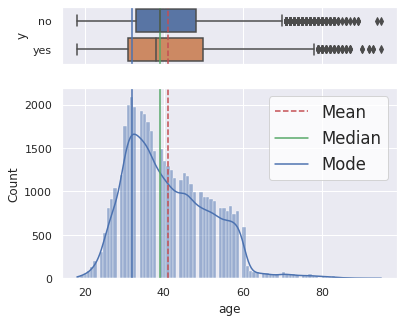

In [316]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=train['age'].mean()
median=train['age'].median()
mode=train['age'].mode().values[0]

age = sns.boxplot(data=train, x="age", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="age", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

#### b. balance Feature
The green line shows a median of 0. It means, most of the people contacted have nearly zero average yearly balance.

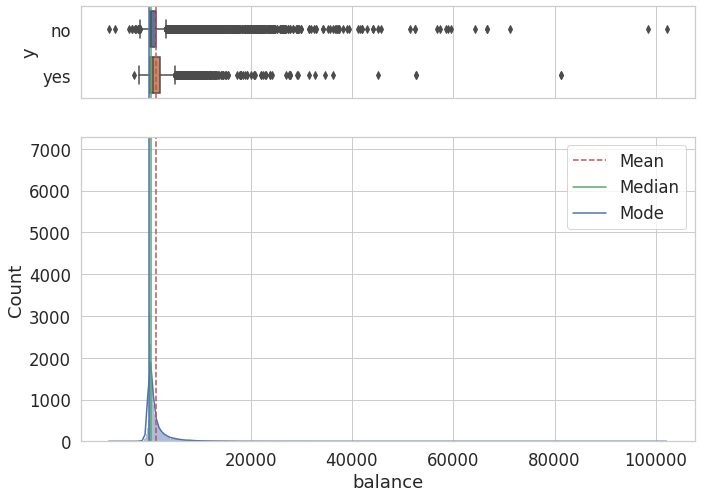

In [317]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=train['balance'].mean()
median=train['balance'].median()
mode=train['balance'].mode().values[0]

balance = sns.boxplot(data=train, x="balance", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="balance", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

#### c. day Feature
The histogram shows a certain symmetry across the entire data set with a peak on day 20. This feature will be removed from the dataset analysis since it does not contribute anything significant to the outcome. Plots show that people can subscribe any day during the week.

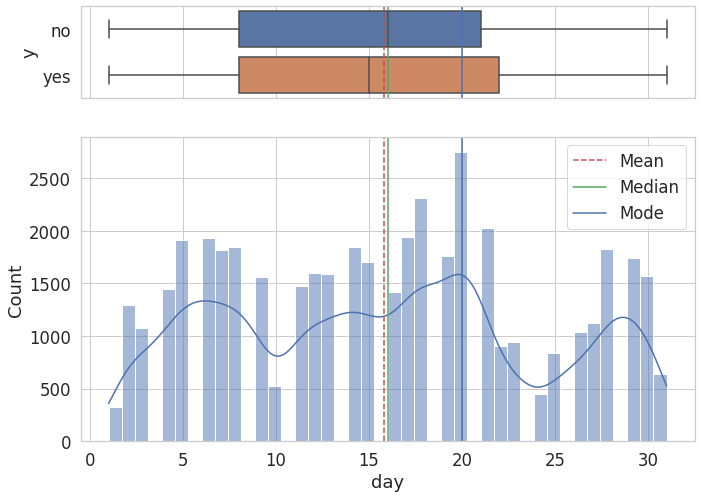

In [318]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=train['day'].mean()
median=train['day'].median()
mode=train['day'].mode().values[0]

day = sns.boxplot(data=train, x="day", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="day", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

#### d. duration Feature
This feature has an influence on the "y" outcome. Below, we can see that when duration is between 0 and the 2 first minutes most of the people reject the offer. The remanent samples take a desicion in a range greater than 2 min up to 12 min. Just a very few take quite a long to both reject or accept the offer.

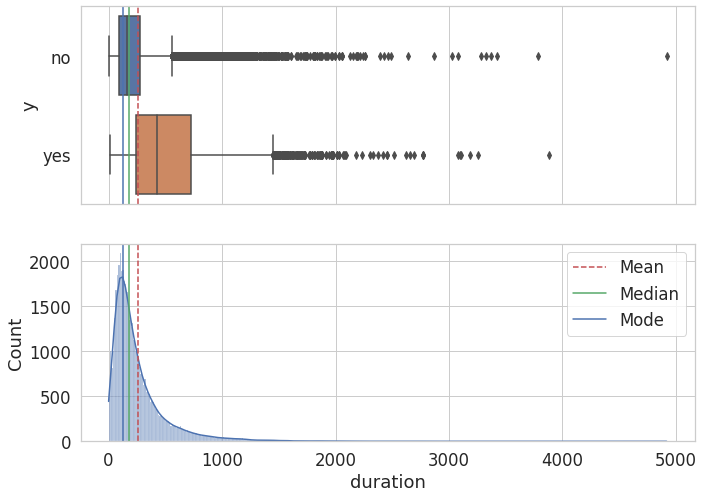

In [319]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True) # gridspec_kw= {"height_ratios": (0.3, 1)}
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=train['duration'].mean()
median=train['duration'].median()
mode=train['duration'].mode().values[0]

duration = sns.boxplot(data=train, x="duration", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="duration", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

#### e. campaign Feature
"Campaign" represenst the number of contacts performed during this campaign. We can see on the plots below that the "yes" and "no" are 50-50. Second, the people who were contacted a few times were the people who decided to subscribe a deposit term. Contrary to this, to try to contact people too many times is a waste of time.

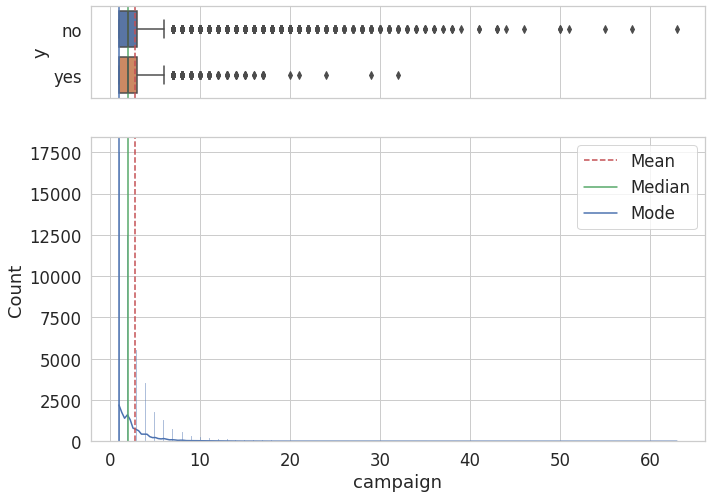

In [320]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=train['campaign'].mean()
median=train['campaign'].median()
mode=train['campaign'].mode().values[0]

campaign = sns.boxplot(data=train, x="campaign", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="campaign", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

#### f. pdays
This feature is the number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted). The median is **-1** and the box-plot reflects that almost most of the people were contacted for the first time. So, this feature will be removed since does not affect the outcome.

40.19782796222158
-1.0


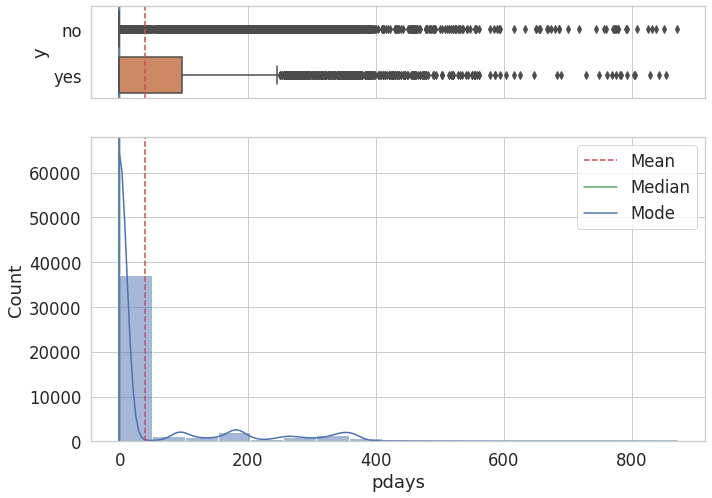

In [321]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')
mean=train['pdays'].mean()
print(mean)
median=train['pdays'].median()
print(median)
mode=train['pdays'].mode().values[0]

pdays = sns.boxplot(data=train, x="pdays", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="pdays", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

#### g. previous
"previous" is the number of contacts performed before this campaign and for this client. As it is shown below, 36954 belong to 0. It means, 36954 were contacted for first time for this campaign. In addition, the box-plot is not present, it does not show a distribution, indicating that there is no relation wrt. the target. It will be removed from the analysis as well.

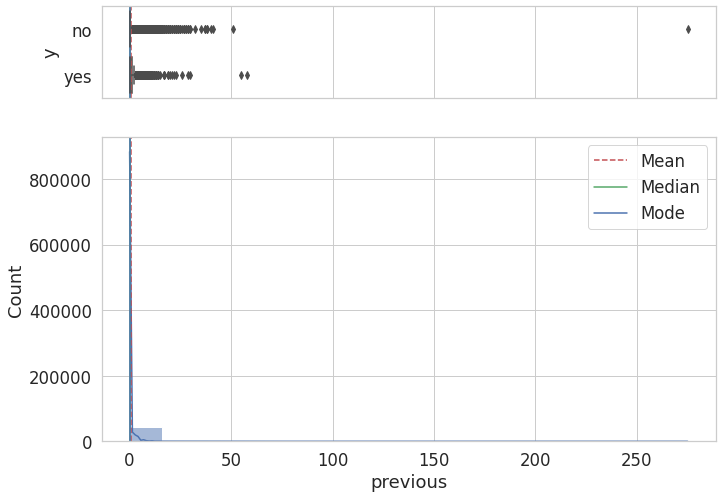

In [322]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.3, 1)})
sns.set(rc={'figure.figsize':(20,17)}, font_scale=1.5, style='whitegrid')
mean=train['previous'].mean()
median=train['previous'].median()
mode=train['previous'].mode().values[0]

previous = sns.boxplot(data=train, x="previous", y="y", ax=ax_box, order = train["y"].value_counts().index)
# age.set(xscale="log")
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.histplot(data=train, x="previous", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")
ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
ax_hist.legend()
ax_box.set(xlabel='')
plt.show()

## 3.	Selecting the appropriate features.
According to the previous analysis the following features are selected to implement a logistic regression model:
* Categorical features: **["job","marital","education","default","housing", "loan", "contact", "poutcome", "y"]**
* Numerical features: **["age", "balance", "duration", "campaign"]**
#### 3.1. Pre-processing
#### 3.2. Removing noise
#### 3.3. Transforming - Encoding


#### 3.1. Preprocessing
I am aware of "data-leake" concept, nevertheless, I combine train and test sets to maintain consistency between them. Furthermore, because I need to encode categorical variables.

In [323]:
train_copy = train.copy()
test_copy = test.copy()

# Set up a flag to distinguish records in the concatenated dataset
train_copy['tst'] = 0
test_copy['tst'] = 1

# Concatenate train and test dataset to perform pre-prepocessing
train_test_concat = pd.concat([train_copy, test_copy], ignore_index=True)
del train_copy
del test_copy
gc.collect()

print(train_test_concat.shape)
print(train.shape)
print(test.shape)

(49732, 18)
(45211, 17)
(4521, 17)


#### 3.2. Removing noise:
The following features  will be removed due to do not represent an impact over the dataset (you can find above the respective explanation of each of the item listed below):
* a. **Replace method** for "unknown" variable in ["job", "education", "contact"].
* b. **Drop features:** ["month", "previous", "day", "pdays"].

In [324]:
# a. Replace method: Mode value
train_test_concat["job"].replace(["unknown"],train_test_concat["job"].mode(),inplace = True)
train_test_concat["education"].replace(["unknown"],train_test_concat["education"].mode(),inplace = True)
train_test_concat["contact"].replace(["unknown"],train_test_concat["contact"].mode(),inplace = True)

In [325]:
# b. Drop unrepresentative features
train_test_concat.drop(columns = ["month", "previous", "day", "pdays"], inplace = True)
print(train_test_concat)

       age            job  marital  education default  balance housing loan  \
0       58     management  married   tertiary      no     2143     yes   no   
1       44     technician   single  secondary      no       29     yes   no   
2       33   entrepreneur  married  secondary      no        2     yes  yes   
3       47    blue-collar  married  secondary      no     1506     yes   no   
4       33    blue-collar   single  secondary      no        1      no   no   
...    ...            ...      ...        ...     ...      ...     ...  ...   
49727   33       services  married  secondary      no     -333     yes   no   
49728   57  self-employed  married   tertiary     yes    -3313     yes  yes   
49729   57     technician  married  secondary      no      295      no   no   
49730   28    blue-collar  married  secondary      no     1137      no   no   
49731   44   entrepreneur   single   tertiary      no     1136     yes  yes   

        contact  duration  campaign poutcome   y  t

#### 3.3. Transforming - Encoding:
* a. **Encoding categorical features**: encodes categorical variables into 1s and 0s (*yes and no become 1 and 0*). When the feature has more than two variables to encode: "marital": married, single, divorced become [1,0,0],[0,1,0], [0,0,1]. For this case is used pd.get_dummies(train["Column_names_here"])

In [326]:
# a. Encoding categorical features.
train_test_concat['default'] = train_test_concat['default'].map({'yes': 1, 'no': 0})
train_test_concat['housing'] = train_test_concat['housing'].map({'yes': 1, 'no': 0})
train_test_concat['loan'] = train_test_concat['loan'].map({'yes': 1, 'no': 0})
train_test_concat['contact'] = train_test_concat['contact'].map({'telephone': 1, 'cellular': 0})
train_test_concat['y'] = train_test_concat['y'].map({'yes': 1, 'no': 0})
train_test_concat

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,poutcome,y,tst
0,58,management,married,tertiary,0,2143,1,0,0,261,1,unknown,0,0
1,44,technician,single,secondary,0,29,1,0,0,151,1,unknown,0,0
2,33,entrepreneur,married,secondary,0,2,1,1,0,76,1,unknown,0,0
3,47,blue-collar,married,secondary,0,1506,1,0,0,92,1,unknown,0,0
4,33,blue-collar,single,secondary,0,1,0,0,0,198,1,unknown,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,services,married,secondary,0,-333,1,0,0,329,5,unknown,0,1
49728,57,self-employed,married,tertiary,1,-3313,1,1,0,153,1,unknown,0,1
49729,57,technician,married,secondary,0,295,0,0,0,151,11,unknown,0,1
49730,28,blue-collar,married,secondary,0,1137,0,0,0,129,4,other,0,1


In [327]:
# a. ['job', 'marital', 'education', 'poutcome'] are categorical variable that are converted into dummy/indicator variables.

train_test_concat = pd.get_dummies(train_test_concat, columns=['job', 'marital', 'education', 'poutcome'])
train_test_concat

,age,default,balance,housing,loan,contact,duration,campaign,y,tst,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,0,261,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,0,151,1,0,0,...,0,0,1,0,1,0,0,0,0,1
2,33,0,2,1,1,0,76,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3,47,0,1506,1,0,0,92,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4,33,0,1,0,0,0,198,1,0,0,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,0,-333,1,0,0,329,5,0,1,...,0,1,0,0,1,0,0,0,0,1
49728,57,1,-3313,1,1,0,153,1,0,1,...,0,1,0,0,0,1,0,0,0,1
49729,57,0,295,0,0,0,151,11,0,1,...,0,1,0,0,1,0,0,0,0,1
49730,28,0,1137,0,0,0,129,4,0,1,...,0,1,0,0,1,0,0,1,0,0


## 4.	Logistic Regression model for classification.
A logistic regression model is to be implemented in order to perform binary classification of each instance, as to whether or not a term deposit will happen.

In [328]:
# Training, Test, & Split
y = train_test_concat["y"]
X = train_test_concat.drop("y",axis = 1)

X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.4, random_state = 42)

# Logistic Regression Model 1: The performance did not improve with data scaling.
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

## 5.	Logistic Regression model evaluation.
The resulting classifier needs to be evaluated, with “accuracy” as the scoring metric.

In [329]:
# Evaluation 1.
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print('Cross Validation mean:',(cross_val_score(logreg, X_train, y_train, cv=5, n_jobs=2, scoring = 'accuracy').mean()))


[[17226  1583]
 [  374   710]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     17600
           1       0.65      0.31      0.42      2293

    accuracy                           0.90     19893
   macro avg       0.79      0.64      0.68     19893
weighted avg       0.89      0.90      0.89     19893

Accuracy: 0.9016236867239733
Precision: 0.6549815498154982
Recall: 0.30963802878325336
Cross Validation mean: 0.8988237473216184


As we can see above results, 92% of the **precisions** were correct, however, **recall** only present 30% of positives cases that were correctly identified and 42% of positive predictions. With this in mind, we confirm once more the imbalance problem related above. So, the oversampling technique is implemented below to solve this issue.

## 6. Oversampling. Overcoming imbalance problem
This method simply duplicates existing samples of a minor class. No synthetic data.
- Split data in train and test sets (X_train_ROS & y_train_ROS).
- Resample only the train set.
- Estimation of the classification quality on the test set.

In [330]:
ROS = RandomOverSampler(sampling_strategy='minority', random_state=1)

X_train_ROS, y_train_ROS = ROS.fit_resample(X_train, y_train)
np.bincount(y_train_ROS)

array([26322, 26322])

In [331]:
# Second test of LR model with oversampling
logreg_oversampling = LogisticRegression(solver='liblinear')
logreg_oversampling.fit(X_train_ROS, y_train_ROS)
y_pred_oversampling = logreg_oversampling.predict(X_test)

In [332]:
# Evaluation 2.
print(confusion_matrix(y_pred_oversampling, y_test))
print(classification_report(y_test, y_pred_oversampling))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_oversampling))
print("Precision:",metrics.precision_score(y_test, y_pred_oversampling))
print("Recall:",metrics.recall_score(y_test, y_pred_oversampling))
print('Cross Validation mean:',(cross_val_score(logreg, X_train, y_train, cv=5, n_jobs=2, scoring = 'accuracy').mean()))

[[14648   514]
 [ 2952  1779]]
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     17600
           1       0.38      0.78      0.51      2293

    accuracy                           0.83     19893
   macro avg       0.67      0.80      0.70     19893
weighted avg       0.90      0.83      0.85     19893

Accuracy: 0.8257678580405168
Precision: 0.3760304375396322
Recall: 0.7758395115569123
Cross Validation mean: 0.8988237473216184


## ROC 1
AUC score for the case is 0.88. AUC score 1 represents perfect classifier.

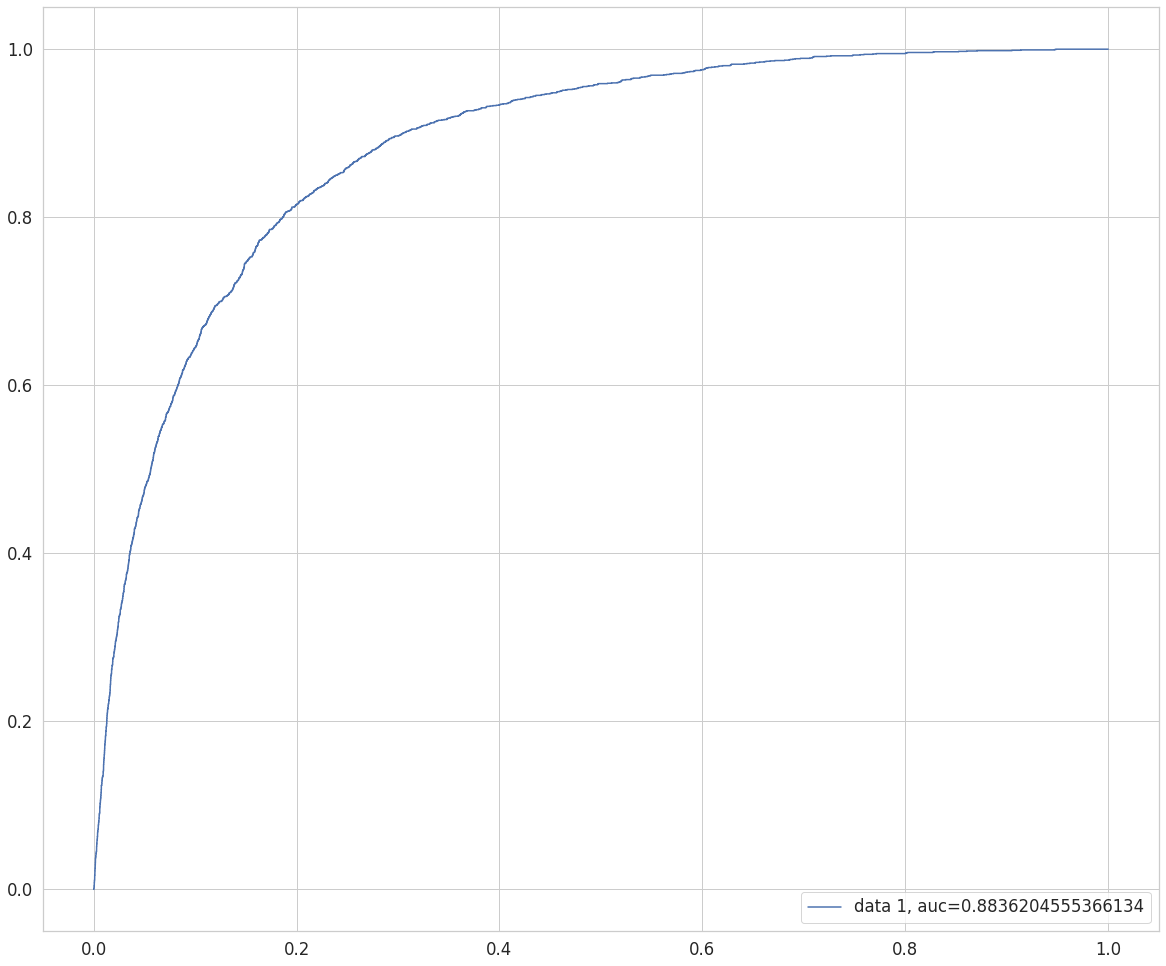

In [333]:
y_pred_proba = logreg_oversampling.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Comments:
* All specifications are detailed and described in this report.
* It is highlighted that the inclusion of oversampling gives substantial improvements to the Logistic Regression model with an accuracy of 82.6%. The recall presents 77,6% of positives cases that were correctly identified which has proved the best method to overcome imbalance data. Also, it was achieved a cross-validation score of 89,88%.
* Time spent in the completion of this report: 8 hours. It took me a little bit longer due to the analysis of each feature and their respective interactions between them as well as the assessment of the different techniques (oversampling, subsampling, SMOT, etc.) to solve the data imbalance problem with the aim to get the highest possible score and improve the performance of the model.